# Before Lecture

- Assignment: follow instrucitons
- Peroject meeting: mandatory

# House Keeping

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pprint import pprint
from statsmodels.iolib.summary2 import summary_col
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS # type: ignore

import seaborn as sns
from causalml.match import NearestNeighborMatch
from causalml.match import create_table_one

# Reading

Textbook Page 139-162.

# ATE

$$ATE= E[y(1)-y(0)]$$
But you can only be on one of them! See [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/).

<img src="https://www.dropbox.com/s/70zizcyax3lqafe/S7_master.png?dl=1">

AB trial is hard or has a high cost.
Social scientists are usually faced with non-random experiments.

- TARP during the financial crisis. Who to save or not?
- Who is eligible for job training benefits?
- What is the value of your master degree?


# Difference-in-differences

I see some change, but that change is mixed. Part of it is due to the treatment, but the other is due to some other shock.
If there is a comparable object that is NOT treated but also experiences the same *other* shock, I can difference it away.

Say object A has change $\Delta y_A = \gamma + \alpha$, where $\alpha$ is *other* shock and $\gamma$ is the treatment effect. Object B is not treated, but it is comparable to A and has $\Delta y_B=\alpha$. Then the difference of the differences is the treatment effect $\gamma = \Delta y_A - \Delta y_B$.

- Assume they are comparable. Not much heterogeneity.



## Search engine marketing (SEM).
- *sponsored* or *paid* search is the advertisement.
  - Try searching "shoes for girls".
  <img src="https://www.dropbox.com/s/co2zwbt5nfq6lp4/shoes.png?dl=1">

- What is the benefit of paying for a search? Does it outweigh the cost?

- eBay stopped bidding on AdWords for 65 of the 210 designed market areas (DMA) in the U.S for 8 weeks following May 22, 2012.

In [ ]:
df_sem = pd.read_csv("https://www.dropbox.com/s/nvcrz2v89hev9ak/paidsearch.csv?dl=1")
df_sem = df_sem.rename(columns={'search stays on': 'search_stays_on'})
df_sem.head()

,date,dma,treatment_period,search_stays_on,revenue
0,1-Apr-12,500,0,0,7.671874e+04
1,1-Apr-12,501,0,1,2.096177e+06
2,1-Apr-12,502,0,1,3.499385e+04
3,1-Apr-12,503,0,1,3.419875e+04
4,1-Apr-12,504,0,1,6.410142e+05


In [ ]:
df_sem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23730 entries, 0 to 23729
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              23730 non-null  object 
 1   dma               23730 non-null  int64  
 2   treatment_period  23730 non-null  int64  
 3   search_stays_on   23730 non-null  int64  
 4   revenue           23730 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 927.1+ KB


## Data Wrangling
Quick summary: total revenue by date and treatment/controls

In [ ]:
totalrev = df_sem.groupby(['date', 'search_stays_on'])['revenue'].sum()
pd.options.display.float_format = '{:.2f}'.format
df_totalrev = pd.DataFrame({'Total_Revenue': totalrev}).reset_index()
df_totalrev

,date,search_stays_on,Total_Revenue
0,1-Apr-12,0,6368245.96
1,1-Apr-12,1,17079414.65
2,1-Jul-12,0,5779481.60
3,1-Jul-12,1,15631990.40
4,1-Jun-12,0,7214375.31
...,...,...,...
221,9-Jul-12,1,20718020.78
222,9-Jun-12,0,5446554.21
223,9-Jun-12,1,14928775.85
224,9-May-12,0,7712905.52


In [ ]:
df_totalrev['date'] = pd.to_datetime(df_totalrev['date'])
df_totalrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             226 non-null    datetime64[ns]
 1   search_stays_on  226 non-null    int64         
 2   Total_Revenue    226 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 5.4 KB


<ipython-input-5-61fb71ea7e38>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_totalrev['date'] = pd.to_datetime(df_totalrev['date'])


Order everything by date

In [ ]:
df_totalrev = df_totalrev.sort_values(by='date')
df_totalrev

,date,search_stays_on,Total_Revenue
0,2012-04-01,0,6368245.96
1,2012-04-01,1,17079414.65
89,2012-04-02,1,20121564.48
88,2012-04-02,0,7687938.41
162,2012-04-03,0,7769392.16
...,...,...,...
99,2012-07-20,1,18410845.72
106,2012-07-21,0,5781874.90
107,2012-07-21,1,15221585.71
114,2012-07-22,0,6196927.48


In [ ]:
df = df_totalrev
df_a1 = df[df['search_stays_on'] == 1]
df_a0 = df[df['search_stays_on'] == 0]

fig = go.Figure()
# Add the first line (Search On)
fig.add_trace(go.Scatter(x=df_a1['date'], y=df_a1['Total_Revenue'], mode='lines',
                         line=dict(color='red'), name='Search On (control)'))
# Add the second line (Search Off)
fig.add_trace(go.Scatter(x=df_a0['date'], y=df_a0['Total_Revenue'], mode='lines',
                         line=dict(color='blue'), name='Search Off (treatment)'))
# Update the layout
fig.update_layout(title='Search On / Off',
                  xaxis_title='Date',
                  yaxis_title='Total Revenue')

# Show the plot
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



## Differences

In [ ]:
df_totalrev1 = df_totalrev.pivot(index='date', columns='search_stays_on', values='Total_Revenue')
df_totalrev1[0]

,0
date,
2012-04-01,6368245.96
2012-04-02,7687938.41
2012-04-03,7769392.16
2012-04-04,7128895.19
2012-04-05,7267948.39
...,...
2012-07-18,7529259.48
2012-07-19,7237067.63
2012-07-20,6916177.35


In [ ]:
df_totalrev1['log_diff'] = np.log(df_totalrev1[1]) - np.log(df_totalrev1[0])

fig = px.line(df_totalrev1, x=df_totalrev1.index, y='log_diff', title='Log Difference of Revenue',
              labels={'date': 'Date', 'log_diff': 'log(rev_control) - log(rev_treat)'},
              line_shape='linear', color_discrete_sequence=['#00b300'])
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
df_sem

,date,dma,treatment_period,search_stays_on,revenue
0,1-Apr-12,500,0,0,76718.74
1,1-Apr-12,501,0,1,2096176.54
2,1-Apr-12,502,0,1,34993.85
3,1-Apr-12,503,0,1,34198.75
4,1-Apr-12,504,0,1,641014.21
...,...,...,...,...,...
23725,22-Jul-12,855,1,1,67234.26
23726,22-Jul-12,862,1,1,269304.79
23727,22-Jul-12,866,1,0,101561.12
23728,22-Jul-12,868,1,1,34645.49


In [ ]:
df_semavg = df_sem.groupby(['dma', 'treatment_period']).agg({'search_stays_on': lambda x: 1 - x.mean(),
                                                      'revenue': lambda x: np.log(x).mean()}).reset_index()

# Rename columns
df_semavg.rename(columns={'treatment_period': 't', 'search_stays_on': 'd', 'revenue': 'y'}, inplace=True)
df_semavg

,dma,t,d,y
0,500,0,1.00,11.23
1,500,1,1.00,11.18
2,501,0,0.00,14.58
3,501,1,0.00,14.56
4,502,0,0.00,10.39
...,...,...,...,...
415,866,1,1.00,11.57
416,868,0,0.00,10.57
417,868,1,0.00,10.50
418,881,0,0.00,11.44


Balance Check

In [ ]:
df_semavg.t.value_counts()

,count
t,
0,210
1,210


In [ ]:
df_semavg.d.value_counts()

,count
d,
0.00,284
1.00,136


In [ ]:
pd.crosstab(df_semavg.t, df_semavg.d)

d,0.00,1.00
t,,
0,142,68
1,142,68


Focus on the interaction term (and its clustered standard errors)

- $t$ takes value of 0 (before) and 1 (after).
- $d$ takes value of 0 (no treatment) and 1 (treatment)

The model is as (5.13)
$$E(y_{it}) = \alpha + \beta_d d_i + \beta_t t + \gamma d_i t.$$

- $\beta_d$ captures the treatment group's property
- $\beta_t$ captures the time effect or any other shocks during the treatment period.
- $\gamma$ is the treatment effect.

In [ ]:
model = smf.ols(formula='y ~ d*t',
                data=df_semavg).fit(cov_type='cluster',
                                    cov_kwds={'groups': df_semavg['dma']})

# Print summary of the regression and clustered standard errors
print(model.summary())
# this report looks nicer than the textbook R procedure.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                     89.64
Date:                Thu, 22 Aug 2024   Prob (F-statistic):           2.53e-37
Time:                        09:35:23   Log-Likelihood:                -669.65
No. Observations:                 420   AIC:                             1347.
Df Residuals:                     416   BIC:                             1363.
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9486      0.104    105.200      0.0

## Individual effects

The DMA could be highly heterogeneous. If eBay choose DMA accordingly, you have missing variable problem. This seems a plausible critic.

You can use DMA fixed effects insted of clustering.
Let's *contorl* them explicitly (5.14) as
$$E(y_{it}) = \alpha_i + \beta_d d_i + \beta_t t + \gamma d_i t.$$


- Now we have subscript $i$ for individual effect $\alpha_i$, instead of $\alpha$ as in (5.13)
- Random and Fixed effext estimation of panel data models.
- How do you compare the new SE to the old ones.

In [ ]:
df_semavg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dma     420 non-null    int64  
 1   t       420 non-null    int64  
 2   d       420 non-null    float64
 3   y       420 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 13.2 KB


## GIGO

- This is actually the **most important** step for data science and ALL statistic/econometric works.
- remember: **garbage in, garbage out**, or [GIGO](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out)

In [ ]:
model = smf.ols(formula='y ~ dma + d*t',
                data=df_semavg).fit(cov_type='cluster',
                                    cov_kwds={'groups': df_semavg['dma']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     70.76
Date:                Thu, 22 Aug 2024   Prob (F-statistic):           8.47e-38
Time:                        09:36:17   Log-Likelihood:                -662.29
No. Observations:                 420   AIC:                             1335.
Df Residuals:                     415   BIC:                             1355.
Df Model:                           4                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3653      0.586     21.090      0.0

$\color{red}{Question:}$ This is nonsense, why?

In [ ]:
model = smf.ols(formula='y ~ C(dma) + d*t',
                data=df_semavg).fit(cov_type='cluster',
                                    cov_kwds={'groups': df_semavg['dma']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     590.7
Date:                Thu, 22 Aug 2024   Prob (F-statistic):           9.89e-87
Time:                        09:37:54   Log-Likelihood:                 1073.1
No. Observations:                 420   AIC:                            -1722.
Df Residuals:                     208   BIC:                            -865.6
Df Model:                         211                                         
Covariance Type:              cluster                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        10.8745      0.002   4881.279

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1894: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 212, but rank is 2



In [ ]:
df_semavg['dma'] = df_semavg['dma'].astype(str)
df_semavg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dma     420 non-null    object 
 1   t       420 non-null    int64  
 2   d       420 non-null    float64
 3   y       420 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 13.2+ KB


In [ ]:
model = smf.ols(formula='y ~ -1+dma + d*t',
                data=df_semavg).fit(cov_type='cluster',
                                    cov_kwds={'groups': df_semavg['dma']})
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 22 Aug 2024   Prob (F-statistic):                nan
Time:                        09:37:22   Log-Likelihood:                 1073.1
No. Observations:                 420   AIC:                            -1722.
Df Residuals:                     208   BIC:                            -865.6
Df Model:                         211                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dma[500]       0.4212   4.67e-05   9014.585      0.0

# Regression Discontinuity Design ([RDD](https://www.princeton.edu/~davidlee/wp/RDDEconomics.pdf))

<img src="https://www.dropbox.com/s/7jsw0p4aghq72xl/RDD.png?dl=1">
Figure 5.4

The framework:
- A *forcing variable* (a.k.a. running variable) decides the treatment or not.
- There are no other confounders affecting the treatment allocation.

Examples:
- Discrimination law is applied to firms with more than 15 employees.
- Free entry to museum before 4 years old.
- Any other clear-cut policies?

Notations:
- $y_i(d)$ potential outcome for user $i$ under treatment $d$.
- $d_i$ is the treatment allocation of user $i$.
- $y_i(d_i)$ is the observed response. You cannot see the outcome for all values of $d$s for $y_i$ in applications!
- Forcing variable $r_i$. W.l.o.g., assume the threshold of interest is always zero. You can always shift the variable by moving the threshold to $0$ if not. Hence,
$$d_i=\mathbb{1}_{[r_i>0]}$$
as in (5.17).

Assumptions
- $[y_i(0), y_i(1)] \perp d_i \mid r_i$.  There is no other confounders once $r_i$ is controlled for.
- Continuity (5.19).
$$E[y_i(d)\mid r=-ɛ]≈E[y_i(d)\mid r=0]≈E[y_i(d)\mid r=ɛ].$$



## Simple Model (5.20).
On the left of 0 when $r_i\in (-\delta, 0)$,
$$E[y_i\mid r_i]=\alpha_0+\beta_0 r_i.$$
On the right of 0 when $r_i\in (0, \delta)$,
$$E[y_i\mid r_i]=\alpha_1+\beta_1 r_i.$$
The first is when $d_i=0$ and the second is $d_i=1$.
Then, the **jump** is
$$E[y_i(1)-y_i(0)\mid r_i=0]=\alpha_1-\alpha_0$$

RDD detects **local** treatment effect. This is a **conditional** ATE for $r_i\approx 0$. This is a limitation of RD.

## Rank Score

- a combination of bids and likelihood of being clicked.
- Ad with a higher score is shown first.
- $y$ is the *revenue*.
- $d$ is the treatment. $d=1$ means the ad is showing up in the mainline, above the main search results. $d=0$ means on a sidebar.
- A reserved price exists. If the score is higher, then the ad shows on the mainline; otherwise on the sidebar.
- The rank score is normalised so that the threshold is $0$.

For details, see Page 148-149.

In [ ]:
D = pd.read_csv("https://www.dropbox.com/s/5tf708jkgaksta2/RD.csv?dl=1")
D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509166 entries, 0 to 509165
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   score   509166 non-null  float64
 1   treat   509166 non-null  int64  
 2   y       509166 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 11.7 MB


In [ ]:
fig = px.box(D, x='score', y='treat', orientation='h', labels={'score': 'rank score minus reserve', 'treat': 'treatment (Ad in Main)'})
fig.update_layout(title='Boxplot of Scores by Treatment')
fig.add_shape(type='line', x0=0, x1=0, line=dict(color='gray', dash='dash'))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

## Sub-sample Means

In [ ]:
w = 3  # Setting the threshold value

# Calculating indices for values above the threshold
above_indices = D[(D['score'] > 0) & (D['score'] < w)].index

# Calculating indices for values below the negative threshold
below_indices = D[(D['score'] < 0) & (D['score'] > -w)].index

In [ ]:
# Calculate means for values above and below the threshold
mua = D.loc[above_indices, 'y'].mean()
mub = D.loc[below_indices, 'y'].mean()

# Calculate treatment effect
te = mua - mub

# Calculate variances for values above and below the threshold
vara = D.loc[above_indices, 'y'].var()
varb = D.loc[below_indices, 'y'].var()

# Calculate standard error of the treatment effect
sdte = np.sqrt(vara / len(above_indices) + varb / len(below_indices)) # type: ignore

# Calculate confidence interval for the treatment effect
confidence_interval = [te - 2 * sdte, te + 2 * sdte]

print("mua (above) = ", mua, "mub (below) = ", mub)
print("Treatment Effect:", te)
print("Confidence Interval:", confidence_interval)

mua (above) =  0.0958958468410722 mub (below) =  0.08104605356757008
Treatment Effect: 0.014849793273502124
Confidence Interval: [0.013050120377497303, 0.016649466169506945]


## LOWESS

Using subsample means is not perfect because locally trends may exist.
In this application, a higher rank score tends to increase revenue.

[Weighted least squares](https://en.wikipedia.org/wiki/Local_regression)
- A nonparametric method to explore local regression and sample statistics for curve fitting.
- Think moving average!
- The fitted value is easy to understand.

In [ ]:
# Fit lowess models for above and below data
fita = sm.nonparametric.lowess(D.loc[above_indices, 'y'], D.loc[above_indices, 'score'])
fitb = sm.nonparametric.lowess(D.loc[below_indices, 'y'], D.loc[below_indices, 'score'])

# Generate range of values for prediction
rr = np.linspace(0.001, w - 0.001, num=100)

# Predictions for above and below data
preda = np.interp(rr, fita[:, 0], fita[:, 1])
predb = np.interp(-rr, fitb[:, 0], fitb[:, 1])

In [ ]:
fig = go.Figure()

# Add lines for predictions
fig.add_trace(go.Scatter(x=-rr[::-1], y=predb[::-1], mode='lines', line=dict(color='red', width=2), name='Below Threshold'))
fig.add_trace(go.Scatter(x=rr, y=preda, mode='lines', line=dict(color='blue', width=2), name='Above Threshold'))

# Set x and y axis labels
fig.update_layout(
    xaxis_title="Rank Score",
    yaxis_title="Revenue",
    xaxis_range=[-3, 3],
)

# Show the plot
fig.show()

## Local linear regression:
$$E[y_i]=\alpha + \gamma d_i + r_i(\beta_0 + \beta_1 d_i)$$

In [ ]:
h = 3  # Window threshold

# Calculate indices for values within the window
window_indices = D[(D['score'] > -h) & (D['score'] < h)].index

# Fit linear regression model using formula
formula = 'y ~ treat * score'
linfit = smf.ols(formula, data=D.loc[window_indices]).fit()

# Print the summary of the linear regression
print(linfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     98.43
Date:                Thu, 22 Aug 2024   Prob (F-statistic):           1.51e-63
Time:                        09:47:52   Log-Likelihood:                 49153.
No. Observations:               58418   AIC:                        -9.830e+04
Df Residuals:                   58414   BIC:                        -9.826e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0820      0.001     69.682      

In [ ]:
print(mua-mub)
print(np.interp(0.00, fita[:, 0], fita[:, 1]) - np.interp(0.00, fitb[:, 0], fitb[:, 1]))
print(linfit.params['treat'])

0.014849793273502124
0.003828656477616807
0.01192160216314554


# Two-stage Least Squares (2SLS) and Instrumental Variables

- IV should sound familiar. Figure 5.8 for a drug testing explanation.
<img src="https://www.dropbox.com/s/qpaeat6i7erm18o/IV.png?dl=1">

(5.23)
$$y=g(x, p)+e, \quad cov(e,p)\neq 0$$

We cannot disentangle the effect on $y$ from $p$ and $e$. This is the key to economic analysis. ML focuses on prediction, such endogeneity is not important. Econometric analysis, instead, wishes to pin down the causality and infer potential policy effects or carry out counterfactual analysis.





## [The Oregon Health Insurance Experiment](https://www.nber.org/programs-projects/projects-and-centers/oregon-health-insurance-experiment?page=1&perPage=50)

2008, Oregon expand its coverage for Medicaid. Because demand is higher than supply, the state used lottery to allocate. This is the Oregon Health Insurance Experiment (OHIE), a randomised controlled AB trial to meausre the treatment effect of Medicaid eligibility (note: NOT access).

- people were tracked for 12 moths.
- Load the $P$ data directly.
- What have we done to get $P$?
- How many original data source files did we use?


## Endogeneity

- Eligible does not mean enrolling.
- We previously investigated the effect of *access*
  - $z$ is random allocation to *access*.
- Now we want to know the actual *enrol*'s effect on health activity.
  - The new treatment $p$ is whether the patient actually enrolled.
  - What might make $p$ endogenous?

In [ ]:
P = pd.read_csv("https://www.dropbox.com/s/yqzrf1ipq43euuz/OHIE_P.csv?dl=1")
P.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23107 entries, 0 to 23106
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   person_id     23107 non-null  int64 
 1   household_id  23107 non-null  int64 
 2   doc_any_12m   23107 non-null  int64 
 3   selected      23107 non-null  int64 
 4   medicaid      23107 non-null  int64 
 5   numhh         23107 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [ ]:
# Stage 1: Linear regression model
stage1_formula = 'medicaid ~ selected + numhh'
stage1_model = sm.OLS.from_formula(stage1_formula, data=P).fit()

# Predict using Stage 1 model
P['phat'] = stage1_model.predict(P)

# Stage 2: Linear regression model with predicted variable
stage2_formula = 'doc_any_12m ~ phat + numhh'
stage2_model = sm.OLS.from_formula(stage2_formula, data=P).fit()

# Print the coefficients of Stage 2 model
print("Coefficients of Stage 2 model:")
print(stage2_model.params)

Coefficients of Stage 2 model:
Intercept      0.56
numhh[T.2]    -0.05
numhh[T.3+]   -0.14
phat           0.21
dtype: float64


However, the standard errors are not this easy:

- It should be covered in Econometrics 2 and 3. We do not go into details here.
- However! It is good to know that the OLS inference formula does NOT work here!

In [ ]:
ols_model = smf.ols(formula="doc_any_12m ~ medicaid + numhh", data=P)
print(ols_model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:            doc_any_12m   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     295.1
Date:                Thu, 22 Aug 2024   Prob (F-statistic):          5.57e-188
Time:                        09:50:56   Log-Likelihood:                -15845.
No. Observations:               23107   AIC:                         3.170e+04
Df Residuals:                   23103   BIC:                         3.173e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5623      0.004    131.327      

In [ ]:
model_formula = 'doc_any_12m ~ 1 + [medicaid~selected] + numhh'
iv_model = IV2SLS.from_formula(model_formula, data=P)

# Fit the IV2SLS model
iv_results = iv_model.fit()

# Print the summary of the IV2SLS regression
print(iv_results.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:            doc_any_12m   R-squared:                      0.0368
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0367
No. Observations:               23107   F-statistic:                    177.76
Date:                Thu, Aug 22 2024   P-value (F-stat)                0.0000
Time:                        09:51:12   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
Intercept       0.5588     0.0072     77.489     0.0000      0.5447      0.5730
numhh[T.2]     -0.0530     0.0070    -7.5254    

$\color{red}{Question:}$ Any change to the key coefficient? Any change to its standard error?

# Matching

- CausalML
- The textbook does not cover this. A good reading is [here](https://towardsdatascience.com/matching-weighting-or-regression-99bf5cffa0d9). Some theories are hard, so I summarise its idea for you here. But the credit goes to **Matteo Courthoud**.

- Assumption 1: unconfoundedness
- Assumption 2: overlap


<img src="https://www.dropbox.com/scl/fi/ghorlcyjgpjt4q3ja7nhm/matching_dark.jpg?rlkey=rrxmqw5zvt0vi839s9dte0duv&st=px46mdr5&dl=1" width=300>

<img src="https://www.dropbox.com/scl/fi/2uh3fzhxvbyrsav9tefyz/match_gender.jpg?rlkey=h4e7fy3c03msxyti6n6867uvd&st=sri62es9&dl=1" width=300>

In [8]:
from week06.dgp_collection import dgp_darkmode
from causalml.match import create_table_one

In [ ]:
df = dgp_darkmode().generate_data() #ignore
df.head()

,read_time,dark_mode,male,age,hours
0,14.4,False,0,43.0,65.6
1,15.4,False,1,55.0,125.4
2,20.9,True,0,23.0,642.6
3,20.0,False,0,41.0,129.1
4,21.5,True,0,29.0,190.2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   read_time  300 non-null    float64
 1   dark_mode  300 non-null    bool   
 2   male       300 non-null    int64  
 3   age        300 non-null    float64
 4   hours      300 non-null    float64
dtypes: bool(1), float64(3), int64(1)
memory usage: 9.8 KB


In [9]:
X = ['male', 'age', 'hours']
table1 = create_table_one(df, 'dark_mode', X)
table1

,Control,Treatment,SMD
Variable,,,
n,151,149,
age,46.01 (9.79),39.09 (11.53),-0.6469
hours,337.78 (464.00),328.57 (442.12),-0.0203
male,0.34 (0.47),0.66 (0.48),0.6732


**SMD** (Standardized Mean Difference) is a numeric measure of the difference between groups for a given variable. For continuous variables, it is calculated as the difference in group means divided by the pooled standard deviation.

- $0.1$ is the usual standard.

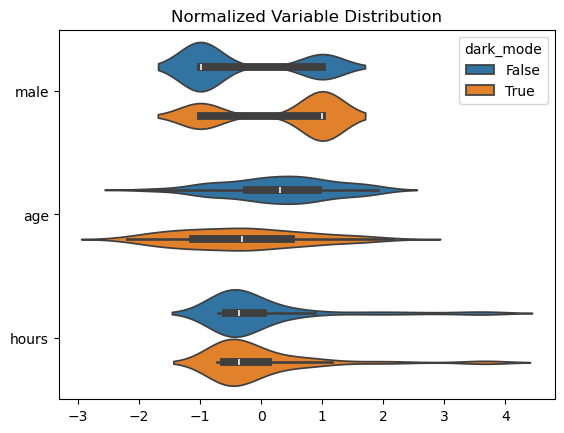

In [16]:
def plot_distributions(df, X, d):
    df_long = df.copy()[X + [d]]
    df_long[X] =(df_long[X] - df_long[X].mean()) / df_long[X].std()
    df_long = pd.melt(df_long, id_vars=d, value_name='value')
    sns.violinplot(y="variable", x="value", hue=d, data=df_long, split=False).set(xlabel="", ylabel="", title="Normalized Variable Distribution")

plot_distributions(df, X, "dark_mode")

## matching

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   read_time  300 non-null    float64
 1   dark_mode  300 non-null    bool   
 2   male       300 non-null    int64  
 3   age        300 non-null    float64
 4   hours      300 non-null    float64
dtypes: bool(1), float64(3), int64(1)
memory usage: 9.8 KB


In [ ]:
df_gender = pd.pivot_table(df, values='read_time', index='male', columns='dark_mode', aggfunc="mean")

dark_mode,False,True
male,,
0,20.318000,22.24902
1,16.933333,16.89898


In [22]:
df_gender.columns

Index([False, True], dtype='bool', name='dark_mode')

In [23]:
df_gender['diff'] = df_gender[True] - df_gender[False] 
df_gender

dark_mode,False,True,diff
male,,,
0,20.318000,22.24902,1.931020
1,16.933333,16.89898,-0.034354


In [ ]:
psm = NearestNeighborMatch(replace=True, ratio=1, random_state=1, caliper=0.2)
# you can adjust caliper to control matching quality. default is 0.2
df_matched = psm.match(data=df, treatment_col="dark_mode", score_cols=X)

In [34]:
df.dark_mode.value_counts(), df_matched.dark_mode.value_counts()

(dark_mode
 False    151
 True     149
 Name: count, dtype: int64,
 dark_mode
 True     104
 False    104
 Name: count, dtype: int64)

In [35]:
table1_matched = create_table_one(df_matched, "dark_mode", X)
table1_matched

,Control,Treatment,SMD
Variable,,,
n,104,104,
age,41.93 (10.05),41.85 (10.02),-0.0086
hours,206.92 (309.62),209.48 (321.79),0.0081
male,0.62 (0.49),0.62 (0.49),0.0


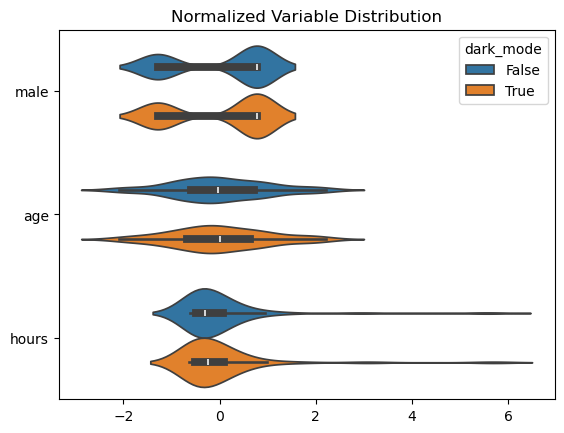

In [36]:
plot_distributions(df_matched, X, "dark_mode")


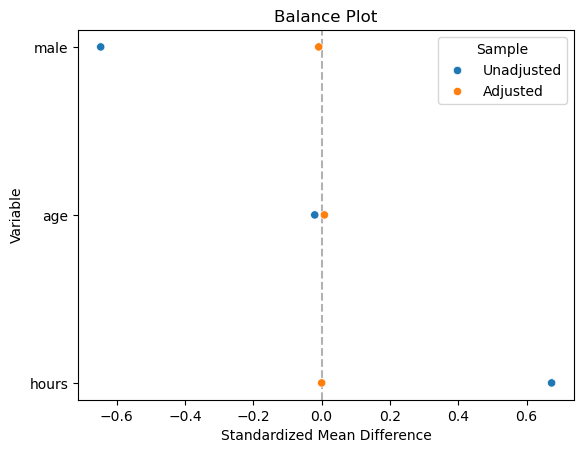

In [ ]:
def plot_balance(t1, t2, X):
    df_smd = pd.DataFrame({"Variable": X + X,
                           "Sample": ["Unadjusted" for _ in range(len(X))] + ["Adjusted" for _ in range(len(X))],
                           "Standardized Mean Difference": t1["SMD"][1:].to_list() + t2["SMD"][1:].to_list()})

    sns.scatterplot(x="Standardized Mean Difference", y="Variable", hue="Sample", data=df_smd).set(title="Balance Plot")
    plt.axvline(x=0, color='k', ls='--', zorder=-1, alpha=0.3);

plot_balance(table1, table1_matched, X)

In [39]:
smf.ols("read_time ~ dark_mode", data=df_matched).fit().summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,17.0365,0.469,36.363,0.000,16.113,17.960
dark_mode[T.True],1.4490,0.663,2.187,0.030,0.143,2.755


# end of file